In [ ]:
import numpy as np
from numpy import linalg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

Рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i),
\\g(w, x) = w^T x
\end{equation}

Реализуем логистическую/сигмоидную функцию потерь: $l(z,y) = \ln (1 + \exp(-yz))$ ($y$ принимает значения $-1$ или $1$).

$\frac{1}{n}\sum\limits_{i = 1}^{n} l(\omega^Т x_i, y_i)=  \frac{1}{n} \sum\limits_{i = 1}^{n}\ln(1 + \exp(-\omega^Tx_iy_i))=  f(\omega)$
#### Вычислим $\nabla f(\omega).\\ df(\omega) = -\frac{1}{n}\sum\limits_{i = 1}^{n}\frac{\exp(-\omega^Tx_iy_i)}{1 + \exp(-\omega^Tx_iy_i)}x_iy_i d\omega\Rightarrow \nabla f(\omega) = -\frac{1}{n}\sum\limits_{i = 1}^{n}\frac{\exp(-\omega^Tx_iy_i)}{1 + \exp(-\omega^Tx_iy_i)}x_iy_i$
#### Вычислим $\nabla^2 f(\omega).\\d^2f(\omega) = \frac{1}{n}\sum\limits_{i = 1}^n \frac{\exp(-\omega^Tx_iy_i)}{(1 + \exp(-\omega^Tx_iy_i))^2}x_ix_i^T(y_i)^2 d\omega\Rightarrow \nabla^2 f(\omega) =  \frac{1}{n}\sum\limits_{i = 1}^n \frac{\exp(-\omega^Tx_iy_i)}{(1 + \exp(-\omega^Tx_iy_i))^2}x_ix_i^T(y_i)^2$.
#### Ввиду того, что $x_ix_i^T$ всегда положительно полуопределена, а остальные множители положительные, то $\nabla^2 f(\omega)$ положительно полуопределена, а значит задача выпуклая.
#### Оценим $L$. Представим гессиан в виде: $\nabla^2 f(\omega) = \frac{1}{n}\sum\limits_{i = 1}^n \frac{1}{(1 + \exp(-\omega^Tx_iy_i))(\frac{1}{\exp(-\omega^Tx_iy_i)} + 1)}x_ix_i^T$. Знаменатель приминает минимальное значение 2, а значит все выражение оценивается сверху, как $\nabla^2 f(\omega) \leq \frac{1}{2n}\sum\limits_{i = 1}^n x_ix_i^T$. Тогда $L$ можно оценить, как самое большое собственное значение $\frac{1}{2n}\sum\limits_{i = 1}^n x_ix_i^T$.

In [ ]:
dataset = "bears.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

y = 2*y - 3
# print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
n_train, d_train = X_train.shape
n_test, d_test = X_test.shape

In [ ]:
L = 1/(2*n_train)*max(np.linalg.eigvalsh(X_train.dot(X_train.T)))
print("L = ", L)

L =  5.169277725744585


In [ ]:
def func(X, y, omega):
    S = 0
    for i in range (n_train):
        expon = np.exp(-omega.T.dot(X[i])*(y[i]))
        S = S + np.log(1 + expon)
    return 1/n_train*S
def gradient(X, y, omega):
    S = 0
    for i in range (n_train):
        expon = np.exp(-omega.T.dot(X[i])*(y[i]))
        S = S + expon/(1 + expon)*X[i]*y[i]
    return -1/n_train*S


In [ ]:
def precisions(omega):
    number_of_true_precisions = 0
    for i in range (n_test):
        if (omega.dot(X_test[i]) > 0):
            k = 1
        else:
            k = -1
        if (k == int(y_test[i])):
            number_of_true_precisions = number_of_true_precisions + 1
    procent_of_precisions = number_of_true_precisions/y_test.shape[0]
    return procent_of_precisions

In [ ]:
def heavy_ball(X, y, start, learning_rate, inertion ,amount_of_iterations):
    omega = start
    omega_arr = [start, start]

    begin_time = time.time()
    timeprog = []
    criterion = []
    precision = []

    for i in range (1, amount_of_iterations):
        grad = gradient(X, y, omega)
        omega = omega - learning_rate*grad + inertion*(omega_arr[1] - omega_arr[0])
        omega_arr[0] = omega_arr[1]
        omega_arr[1] = omega
        timeprog.append(time.time() - begin_time)
        criterion.append(np.linalg.norm(grad)**2)
        precision.append(precisions(omega))
    return criterion, precision, timeprog

In [ ]:
HB = heavy_ball(X_train, y_train, np.zeros(d), 1/L, 0.99, 1000)

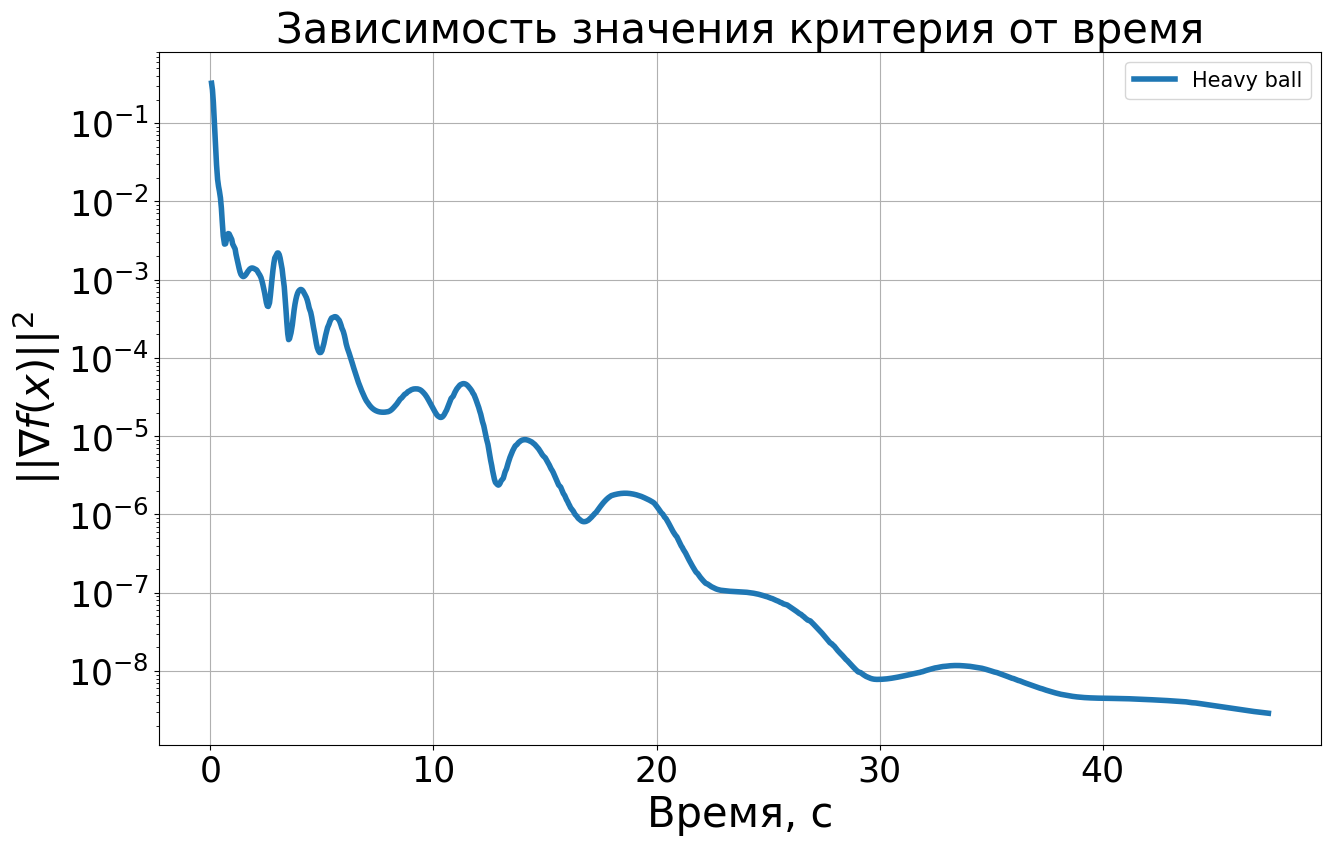

In [ ]:
plt.figure(figsize=(15, 9))

plt.semilogy(HB[2], HB[0], linewidth=4, label = 'Heavy ball')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Время, с", fontsize=30)
plt.ylabel(r"$||\nabla f(x)||^2$", fontsize=30)
plt.title(r"Зависимость значения критерия от время", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()

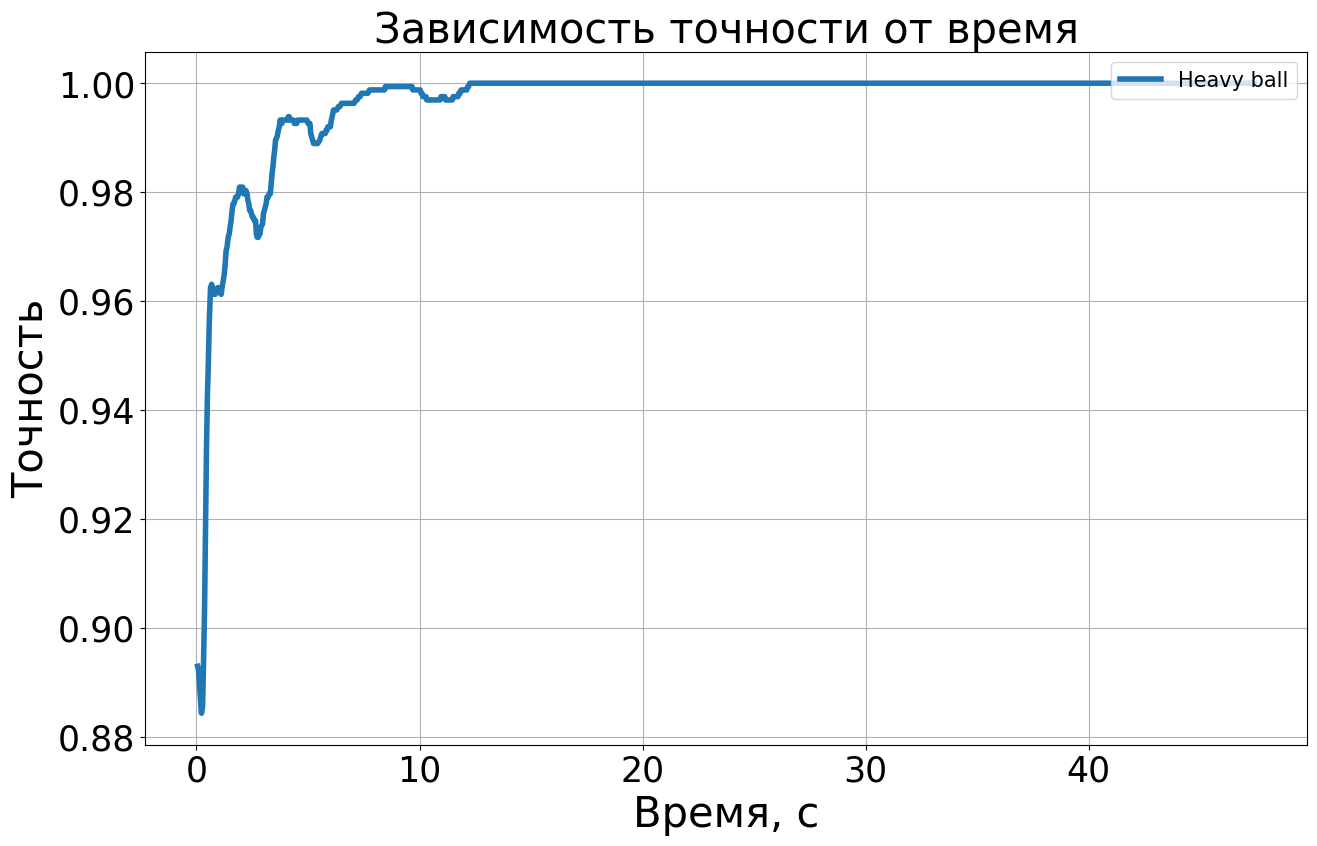

In [ ]:
plt.figure(figsize=(15, 9))

plt.plot(HB[2], HB[1], linewidth=4, label = 'Heavy ball')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Время, с", fontsize=30)
plt.ylabel(r"Точность", fontsize=30)
plt.title(r"Зависимость точности от время", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()